# Notebook to Calculate to isoprenol production 

In this notebook, we estimate the isoprenol concentration for wild type e.coli (model details given below) as well as for strains with some reactions modified

As the first step we load all modules required in cell 1. If this notebook is run on jprime, make sure to use "biodesign_3.7" kernel which in turn has all required modules installed. For more details about the kernel, contact Jose Manuel Marti or Mark Kulawik.


In [2]:
import cobra
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

### Loading the e.coli genome scale model (GEM) which was modified to add isoprenol pathway

For more details about the modification to the 'iJO1366' e.coli genome scale model refer to the jupyter notebook 'add_isopentenol_to_iJO1366.ipynb'

In [3]:
model = cobra.io.load_json_model('./models/iJO1366_MVA.json')
model.summary()

#### Setting the solver to cplex and storing the biomass and isoprenol expression to simpler strings so that they can be referred easily

In [4]:
model.solver = 'cplex'
biomass = 'BIOMASS_Ec_iJO1366_core_53p95M'
iso = 'EX_isoprenol_e'

#### Loading the training data which contains which reactions are to be modified for a strain

In [5]:
# data_filename = './data/training_data_8reactions.csv'
# data_filename = './results_ordinal/recommendations_exploit.csv'
data_filename = './results_ordinal/recommendations_explor.csv'
sep = '\t'

df = pd.read_csv(data_filename,sep)
df.head()

,Unnamed: 0,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683176
1,1,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681792
2,2,2.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681940
3,3,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.677444
4,4,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683688


In [6]:
df = df.rename(columns={'Isoprenol [mM]': 'Isoprenol [mM] Pred'})
df.head()

,Unnamed: 0,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM] Pred
0,0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683176
1,1,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681792
2,2,2.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681940
3,3,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.677444
4,4,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683688


#### Calculating the number of reactions that should be modified (n_genes) and number of strains for which isoprenol concentration should be estimated 

In [7]:
n_genes = df.shape[1] - 1
n_instances = df.shape[0] - 1
#rec 
n_genes = df.shape[1] - 2
n_instances = df.shape[0] 
print(n_genes,n_instances)

8 96


#### Inserting the isoprenol concentration as the last column in the dataframe

In [8]:
# df.insert(loc=n_genes+1,column='Isoprenol [mM]',value=None)

In [9]:
df.insert(loc=n_genes+2,column='Isoprenol [mM]',value=None)

The original e.coli iJO1366 model does not isoprenol pathway. Thus, performing simple flux balance analysis on the model will not allocate any flux for isoprenol production reaction. So, we modify the model so that it produces a small amount of isoprenol. In addition, we force a small amount of formate production which forces the model to activate the 'PFL' reaction.

In [10]:
with model:
    display(model.summary())
    # Constraint to force a small amount of isoprenol production
    iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,
                                lb = 0.20)
    # Adding the constraint to the model
    model.add_cons_vars(iso_cons)
    # Constraint to force a small amount of formate production which would activate the "PFL" reaction
    for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,
                                lb = 0.10)
    # Adding the constraint to the model
    model.add_cons_vars(for_cons)
    WT_FBA_sol = cobra.flux_analysis.pfba(model)
    print(WT_FBA_sol.status, WT_FBA_sol[biomass], WT_FBA_sol[iso])

optimal 0.957904309767392 0.2


#### Giving initial concentrations to the substrates that are generally fed to the cells

In [11]:
# volume is arbitrarily set to 1 ml
volume = 1.0
comp = ['glc__D_e', 'nh4_e', 'pi_e', 'so4_e', 'mg2_e', 'k_e', 'na1_e', 'cl_e']
subs0 = [22.203, 18.695, 69.454, 2.0, 2.0, 21.883, 103.7, 27.25] # in mM
cell0 = 0.01 # in gDW/L

In [12]:
subs_ext = {r.id: r.reactants[0].id for r in model.exchanges if r.reactants[0].id in comp}
subs_ext

{'EX_glc__D_e': 'glc__D_e',
 'EX_k_e': 'k_e',
 'EX_mg2_e': 'mg2_e',
 'EX_na1_e': 'na1_e',
 'EX_nh4_e': 'nh4_e',
 'EX_cl_e': 'cl_e',
 'EX_pi_e': 'pi_e',
 'EX_so4_e': 'so4_e'}

#### Timescale is set from 0 to 8 at 1 hour interval

In [13]:
t0 = 0.0
tf = 8.0
pts = 9
tspan = np.linspace(t0, tf, pts)
delt = tspan[1] - tspan[0]
cell = pd.Series(index=tspan)
cell[t0] = cell0
subs = pd.DataFrame(index=tspan, columns=comp)
subs.loc[t0] = subs0
conc_iso = pd.Series(index=tspan)
conc_iso[t0] = 0.0
sol_time_wild = pd.Series(index=tspan)

In [14]:
# For each timepoint
for t in tspan:
    # Not changing the model but adding constraints for each time point
    with model:
        for k, v in subs_ext.items():
            model.reactions.get_by_id(k).lower_bound = max(model.reactions.get_by_id(k).lower_bound,
                                                           -subs.loc[t,v]*volume/cell[t]/delt) 
        iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,
                                lb = 0.20)
        model.add_cons_vars(iso_cons)
        for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,
                                lb = 0.10)
        model.add_cons_vars(for_cons)
#        display(model.summary())
        sol_t = model.optimize()
        # storing the solution for each timepoint which are going to be reference solutions for moma (see below)
        sol_time_wild[t] = sol_t
        mu = sol_t[biomass]
        print(t, sol_t.status, mu)
        if sol_t.status == 'optimal' and mu > 1e-6:
            # Calculating next time point's OD
            cell[t+delt] = cell[t]*np.exp(mu*delt)
            for k, v in subs_ext.items():
                # Calculating substrate's concentration for next time point
                subs.loc[t+delt,v] = max(subs.loc[t,v]-sol_t[k]/mu*cell[t]*(1-np.exp(mu*delt)),0.0)
            if sol_t[iso] > 0:
                # Calculating isoprenol concentration for next time point
                conc_iso.loc[t+delt] = conc_iso.loc[t]-sol_t[iso]/mu*cell[t]*(1-np.exp(mu*delt))
            else:
                conc_iso.loc[0:t] = 0
                conc_iso.loc[t+delt] = conc_iso.loc[t]-sol_t[iso]/mu*cell[t]*(1-np.exp(mu*delt))
        else:
            cell[t+delt] = cell[t]
            for k, v in subs_ext.items():
                subs.loc[t+delt,v] = subs.loc[t,v]
            conc_iso.loc[t+delt] = conc_iso.loc[t]
t = 8
cell = cell[0:t]
subs = subs.loc[0:t]
conc_iso = conc_iso.loc[0:t]
# Storing final time point's isoprenol concentration

# Is this only for the WT? It shouldn't be here in the package
# df.iloc[n_instances,9] = conc_iso.iloc[-1]

0.0 optimal 0.9579043097673936
1.0 optimal 0.9579043097673949
2.0 optimal 0.9579043097673939
3.0 optimal 0.9579043097673939
4.0 optimal 0.9579043097673942
5.0 optimal 0.44779698359777137
6.0 infeasible 0.0
7.0 infeasible 0.0
8.0 infeasible 0.0


cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


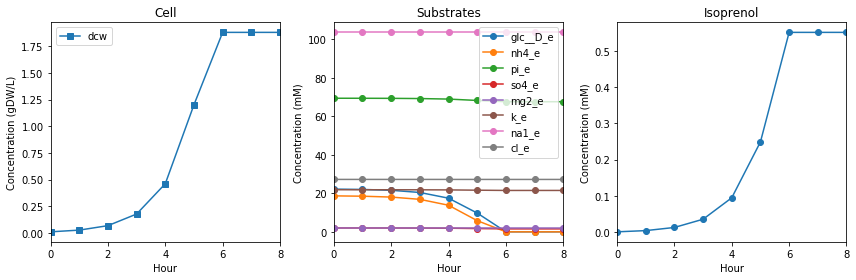

In [15]:
fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)
cell.plot(ax=ax[0], style='s-', title='Cell', label='dcw', legend=True)
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Concentration (gDW/L)")
subs.plot(ax=ax[1], style='o-', title='Substrates')
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Concentration (mM)")
conc_iso.plot(ax=ax[2], style='o-', title='Isoprenol')
ax[2].set_xlabel("Hour")
ax[2].set_ylabel("Concentration (mM)")
plt.tight_layout()

In [16]:
%%time
# For each strain
for i in range(0,n_instances):
    # At each time point
    for t in tspan:
        # Adding constraints to the model at each time point for each strain without globally changing the model
        with model:
            for k, v in subs_ext.items():
                model.reactions.get_by_id(k).lower_bound = max(model.reactions.get_by_id(k).lower_bound,
                                                           -subs.loc[t,v]*volume/cell[t]/delt)
            # Adding the fluxed modifications for chosen reactions
            cons1 = model.problem.Constraint(model.reactions.ACCOAC.flux_expression, 
                                            lb = WT_FBA_sol['ACCOAC']*df.iloc[i,1],
                                            ub = WT_FBA_sol['ACCOAC']*df.iloc[i,1])
            model.add_cons_vars(cons1)
        
            cons2 = model.problem.Constraint(model.reactions.MDH.flux_expression,
                                            lb = WT_FBA_sol['MDH']*df.iloc[i,2],
                                            ub = WT_FBA_sol['MDH']*df.iloc[i,2])
            model.add_cons_vars(cons2)
        
            cons3 = model.problem.Constraint(model.reactions.PTAr.flux_expression,
                                            lb = WT_FBA_sol['PTAr']*df.iloc[i,3],
                                            ub = WT_FBA_sol['PTAr']*df.iloc[i,3])
            model.add_cons_vars(cons3)
        
            cons4 = model.problem.Constraint(model.reactions.CS.flux_expression,
                                            lb = WT_FBA_sol['CS']*df.iloc[i,4],
                                            ub = WT_FBA_sol['CS']*df.iloc[i,4])
            model.add_cons_vars(cons4)
        
            cons5 = model.problem.Constraint(model.reactions.ACACT1r.flux_expression,
                                            lb = WT_FBA_sol['ACACT1r']*df.iloc[i,5],
                                            ub = WT_FBA_sol['ACACT1r']*df.iloc[i,5])
            model.add_cons_vars(cons5)
        
            cons6 = model.problem.Constraint(model.reactions.PPC.flux_expression,
                                            lb = WT_FBA_sol['PPC']*df.iloc[i,6],
                                            ub = WT_FBA_sol['PPC']*df.iloc[i,6])
            model.add_cons_vars(cons6)
        
            cons7 = model.problem.Constraint(model.reactions.PPCK.flux_expression,
                                            lb = WT_FBA_sol['PPCK']*df.iloc[i,7],
                                            ub = WT_FBA_sol['PPCK']*df.iloc[i,7])
        
            model.add_cons_vars(cons7)
        
            cons8 = model.problem.Constraint(model.reactions.PFL.flux_expression,
                                            lb = WT_FBA_sol['PFL']*df.iloc[i,8],
                                            ub = WT_FBA_sol['PFL']*df.iloc[i,8])
        
            model.add_cons_vars(cons8)
            
            # Reference solution calculated for each time point in above cell for wild type
            sol1 = sol_time_wild[t]
            # Moma solution for each time point
            sol2 = cobra.flux_analysis.moma(model, solution=sol1, linear=False)
            mu = sol2[biomass]
            print(i,t, sol2.status, mu)
            if sol2.status == 'optimal' and mu > 1e-6:
                cell[t+delt] = cell[t]*np.exp(mu*delt)
                for k, v in subs_ext.items():
                    subs.loc[t+delt,v] = max(subs.loc[t,v]-sol2[k]/mu*cell[t]*(1-np.exp(mu*delt)),0.0)
                if sol2[iso] > 0:
                    conc_iso.loc[t+delt] = conc_iso.loc[t]-sol2[iso]/mu*cell[t]*(1-np.exp(mu*delt))
                else:
                    conc_iso.loc[0:t] = 0
                    conc_iso.loc[t+delt] = conc_iso.loc[t]-sol2[iso]/mu*cell[t]*(1-np.exp(mu*delt))
            else:
                cell[t+delt] = cell[t]
                for k, v in subs_ext.items():
                    subs.loc[t+delt,v] = subs.loc[t,v]
                conc_iso.loc[t+delt] = conc_iso.loc[t]
    t = 8
    cell = cell[0:t]
    subs = subs.loc[0:t]
    conc_iso = conc_iso.loc[0:t]
    print(conc_iso)
    # Storing the final concentration for all strains
#     df.iloc[i,9] = conc_iso.iloc[-1]
    df.iloc[i,10] = conc_iso.iloc[-1]
    print(i,sol2[iso],conc_iso.iloc[-1])

0 0.0 optimal 0.8300950270004455
0 1.0 optimal 0.8300953073592657
0 2.0 optimal 0.8300909748476452
0 3.0 optimal 0.8300906944887989
0 4.0 optimal 0.8300906944888123
0 5.0 optimal 0.2034648032462369
0 6.0 optimal 0.0
0 7.0 optimal 0.0
0 8.0 optimal 0.0
0.0    0.000000
1.0    0.008356
2.0    0.027522
3.0    0.071481
4.0    0.172301
5.0    0.403534
6.0    0.724305
7.0    0.724305
8.0    0.724305
dtype: float64
0 0.0 0.7243049948738917
1 0.0 optimal 0.7489027074804865
1 1.0 optimal 0.7489042429235805
1 2.0 optimal 0.7488966052317433
1 3.0 optimal 0.7488950697885756
1 4.0 optimal 0.748895069788574
1 5.0 optimal 0.2618029769633554
1 6.0 optimal 0.0
1 7.0 optimal 0.0
1 8.0 optimal 0.0
0.0    0.000000
1.0    0.010025
2.0    0.031225
3.0    0.076056
4.0    0.170858
5.0    0.371334
6.0    0.654100
7.0    0.654100
8.0    0.654100
dtype: float64
1 0.0 0.6540998980251679
2 0.0 optimal 0.8366506588796754
2 1.0 optimal 0.836650658837595
2 2.0 optimal 0.8366501934777766
2 3.0 optimal 0.836650193520061

In [17]:
df.head()

,Unnamed: 0,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM] Pred,Isoprenol [mM]
0,0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683176,0.724305
1,1,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681792,0.6541
2,2,2.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681940,0.70928
3,3,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.677444,0.715313
4,4,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683688,0.62838


In [18]:
len(df[df['Isoprenol [mM]']>0.55])

93

In [23]:
max(df['Isoprenol [mM]'])

0.768143414363524

In [26]:
data_initial = pd.read_csv('./data/training_data_8reactions_iso.csv')

In [27]:
max(data_initial['Isoprenol [mM]'])

0.73851582768313

In [28]:
0.768143414363524/0.73851582768313

1.0401177409742748

In [25]:
max(data_initial['Isoprenol [mM]'])

0.6252409460370562

In [19]:
# data_filename = f'./data/training_data_{n_genes}reactions_withIso.csv'
# df.to_csv(data_filename, header=True, index=False)


In [20]:
data_filename = f'./results_ordinal/recommendations_explor_obs.csv'
df.to_csv(data_filename, header=True, index=False)
